In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../../data/통합데이터/필터된 데이터.csv")

In [3]:
# 2. 결측치 처리 (안전장치)
df['증감율_이용금액_신용_전월'] = df['증감율_이용금액_신용_전월'].fillna(0)
df['연체잔액_B0M'] = df['연체잔액_B0M'].fillna(0)

# 3. 이탈 위험군 조건 정의 (4가지)
cond_status = (df['회원여부_이용가능'] == 0)
cond_inactive = (df['연속무실적개월수_기본_24M_카드'] >= 2)
cond_drop = (df['증감율_이용금액_신용_전월'] <= -0.3)
cond_overdue = (df['연체잔액_B0M'] > 0)

# 4. [핵심] 옆에 피쳐 하나 만들기! (Churn_Refined)
df['Churn_Refined'] = np.where(cond_status | cond_inactive | cond_drop | cond_overdue, 1, 0)

# 5. 결과 확인 (눈으로 직접 보기)
print("새로 생긴 컬럼 확인:")
print(df[['발급회원번호', 'Churn_Refined']].head()) # 회원번호 옆에 딱 붙었는지 확인!

새로 생긴 컬럼 확인:
  발급회원번호  Churn_Refined
0  SYN_0              0
1  SYN_1              1
2  SYN_2              1
3  SYN_3              0
4  SYN_4              1


In [4]:
features = df.columns

In [ ]:
# with open('output.txt', 'w', encoding='utf-8') as f:
#     f.write('\n'.join(features))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 462 entries, 기준년월 to Churn_Refined
dtypes: float64(52), int64(382), object(28)
memory usage: 211.5+ MB


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

# df = pd.read_csv("Final_merged_all_data.csv") 

# -------------------------------------------------------
# 1. 소비 감소 기울기 (Trend Slope) - 잔액 데이터 활용
# -------------------------------------------------------
# Columns.txt에 있는 정확한 명칭으로 매핑
cols_balance = [
    '잔액_일시불_B2M', '잔액_할부_B2M', 
    '잔액_일시불_B1M', '잔액_할부_B1M', 
    '잔액_일시불_B0M', '잔액_할부_B0M'
]

# 결측치 0 처리
for col in cols_balance:
    if col in df.columns:
        df[col] = df[col].fillna(0)
    else:
        print(f"⚠️ 경고: {col} 컬럼이 없습니다.")

# 월별 총 잔액 계산
df['Balance_Total_B2M'] = df['잔액_일시불_B2M'] + df['잔액_할부_B2M']
df['Balance_Total_B1M'] = df['잔액_일시불_B1M'] + df['잔액_할부_B1M']
df['Balance_Total_B0M'] = df['잔액_일시불_B0M'] + df['잔액_할부_B0M']

# 기울기 계산 함수
def calc_balance_slope(row):
    y = np.array([row['Balance_Total_B2M'], row['Balance_Total_B1M'], row['Balance_Total_B0M']])
    x = np.array([0, 1, 2]) 
    
    if np.sum(y) == 0: return 0
    
    slope, _, _, _, _ = linregress(x, y)
    mean_val = np.mean(y)
    return slope / mean_val if mean_val != 0 else 0

print("1. 잔액 감소 추세(Slope) 계산 중...")
df['Trend_Slope_Balance'] = df.apply(calc_balance_slope, axis=1)


# -------------------------------------------------------
# 2. 활동성 급감 (Activity Drop) - 이용금액 활용
# -------------------------------------------------------
# 컬럼명 수정: 이용금액_R3M_신용 -> 이용금액_신용_R3M
# 컬럼명 대체: 이용금액_신판_B0M -> 이용금액_신용_B0M (신용=일시불+할부+청구할인후 금액 등)

if '이용금액_신용_R3M' in df.columns and '이용금액_신용_B0M' in df.columns:
    # R3M은 3개월 합계이므로 월평균으로 변환
    df['Avg_Spend_R3M'] = df['이용금액_신용_R3M'] / 3
    
    # 0으로 나누기 방지
    df['Activity_Ratio'] = np.where(df['Avg_Spend_R3M'] > 0, 
                                    df['이용금액_신용_B0M'] / df['Avg_Spend_R3M'], 
                                    1.0)
else:
    print("⚠️ 이용금액 관련 컬럼이 확인되지 않아 Activity_Ratio를 1로 설정합니다.")
    df['Activity_Ratio'] = 1.0


# -------------------------------------------------------
# 3. 위험 점수 (Risk Score) - 수신거부 제외 및 대체
# -------------------------------------------------------
df['Risk_Score'] = 0

# (1) 연체 (50점)
if '연체잔액_B0M' in df.columns:
    df['Risk_Score'] += np.where(df['연체잔액_B0M'] > 0, 50, 0)

# (2) 현금서비스 과다 (20점)
if '잔액_현금서비스_B0M' in df.columns:
    df['Risk_Score'] += np.where(df['잔액_현금서비스_B0M'] > 1000000, 20, 0)

# (3) [대체] 승인 거절 발생 (10점) -> 수신거부 대신 사용
# Columns.txt에 '승인거절건수_B0M' 존재함
if '승인거절건수_B0M' in df.columns:
    df['Risk_Score'] += np.where(df['승인거절건수_B0M'] > 0, 10, 0)


# -------------------------------------------------------
# 4. 최종 타겟 생성
# -------------------------------------------------------
# 조건: 기울기 급락(-0.5 이하) OR 활동성 급감(30% 이하) OR 고위험군(50점 이상)
df['Churn_Probabilistic'] = np.where(
    (df['Trend_Slope_Balance'] <= -0.5) | 
    (df['Activity_Ratio'] <= 0.3) | 
    (df['Risk_Score'] >= 50),
    1, 0
)

print("\n[최종 결과 확인]")
print(df[['발급회원번호', 'Trend_Slope_Balance', 'Activity_Ratio', 'Risk_Score', 'Churn_Probabilistic']].head(10))
print("\n이탈 예측 비율:")
print(df['Churn_Probabilistic'].value_counts(normalize=True))

1. 잔액 감소 추세(Slope) 계산 중...

[최종 결과 확인]
  발급회원번호  Trend_Slope_Balance  Activity_Ratio  Risk_Score  Churn_Probabilistic
0  SYN_0             0.020411        1.008718          20                    0
1  SYN_1             0.066994        0.600829           0                    0
2  SYN_2            -0.994687        0.000000           0                    1
3  SYN_3             0.001011        2.206591           0                    0
4  SYN_4             0.000000        1.000000           0                    0
5  SYN_5             0.000000        1.000000           0                    0
6  SYN_6             0.000000        1.000000           0                    0
7  SYN_7            -0.127596        1.000000           0                    0
8  SYN_8            -0.116592        0.892885           0                    0
9  SYN_9            -0.178058        1.723683           0                    0

이탈 예측 비율:
Churn_Probabilistic
0    0.935333
1    0.064667
Name: proportion, dtype: float64


In [8]:
df['Churn_Probabilistic'].value_counts(normalize=True)

Churn_Probabilistic
0    0.935333
1    0.064667
Name: proportion, dtype: float64

강제 설정된 폰트: Malgun Gothic


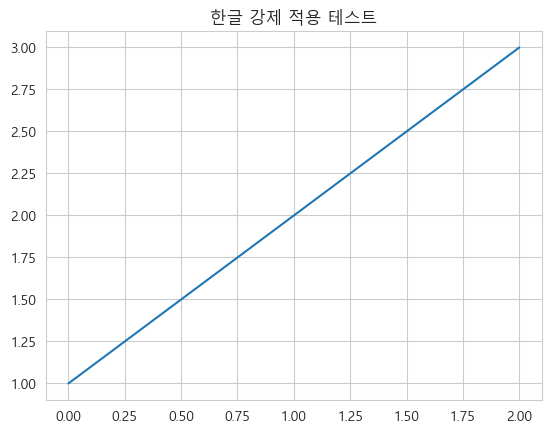

In [13]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 윈도우의 '맑은 고딕' 폰트 파일 경로를 직접 지정
font_path = "C:/Windows/Fonts/malgun.ttf"

# 폰트 매니저에 경로 등록
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)

print(f"강제 설정된 폰트: {font_name}")

# 테스트
plt.title("한글 강제 적용 테스트")
plt.plot([1, 2, 3])
plt.show()

C:\Users\johnh\AppData\Local\Temp\ipykernel_13608\3827069317.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn_Probabilistic', y='Trend_Slope_Balance', data=df, ax=axes[0, 1], palette="coolwarm")
C:\Users\johnh\AppData\Local\Temp\ipykernel_13608\3827069317.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['일반 고객', '이탈 위험군'])
C:\Users\johnh\AppData\Local\Temp\ipykernel_13608\3827069317.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Churn_Probabilistic'] == 0]['Activity_Ratio'], shade=True, color="blue", label="일반 고객", ax=axes[1, 0])
C:\Users\johnh\AppData\Local\Temp\ipykerne

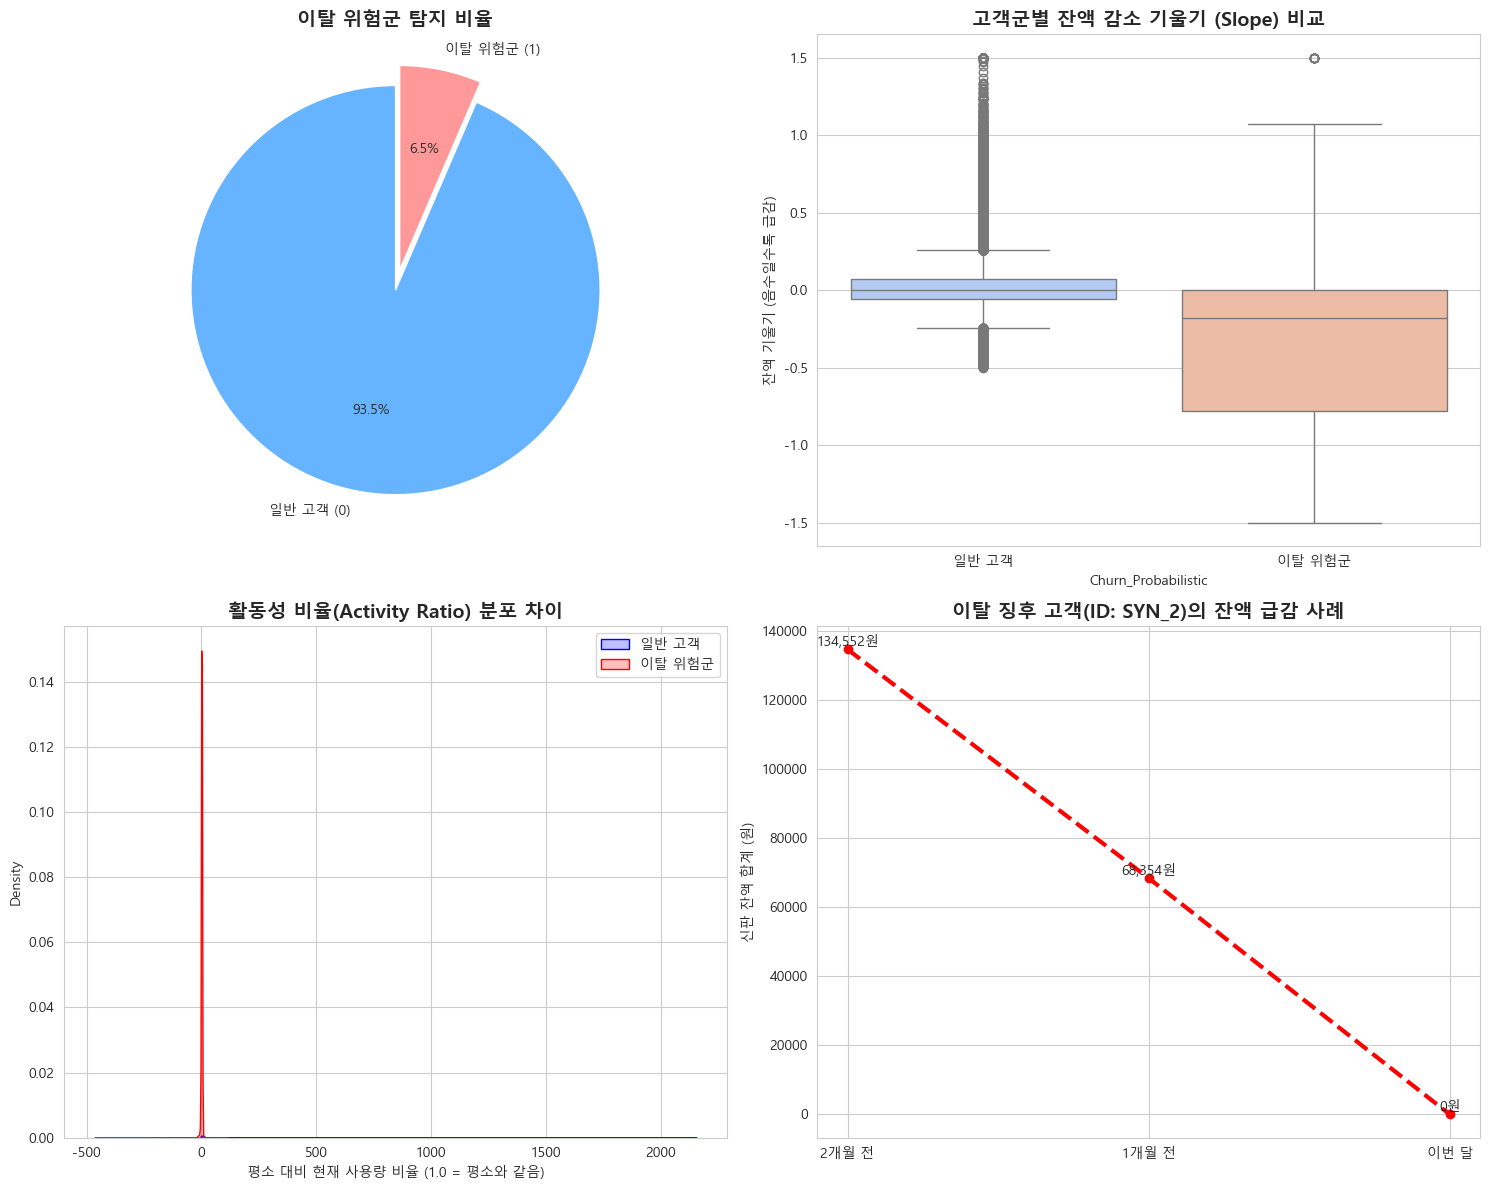

In [14]:

# -------------------------------------------------------
# 2. 시각화 그리기
# -------------------------------------------------------
# 그림판 크기 설정 (가로 2개, 세로 2개)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# (1) 이탈 위험군 vs 일반 고객 비율 (Pie Chart)
# 목적: 우리가 정의한 타겟 변수로 분류했을 때, 위험군이 얼마나 되는지 확인
churn_counts = df['Churn_Probabilistic'].value_counts()
labels = ['일반 고객 (0)', '이탈 위험군 (1)']
colors = ['#66b3ff', '#ff9999']

axes[0, 0].pie(churn_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0, 0.1))
axes[0, 0].set_title('이탈 위험군 탐지 비율', fontsize=14, fontweight='bold')


# (2) 잔액 감소 추세(Slope) 비교 (Box Plot)
# 목적: 이탈 위험군(1)이 일반 고객(0)보다 확실히 잔액이 줄어드는지(음수) 증명
sns.boxplot(x='Churn_Probabilistic', y='Trend_Slope_Balance', data=df, ax=axes[0, 1], palette="coolwarm")
axes[0, 1].set_title('고객군별 잔액 감소 기울기 (Slope) 비교', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(['일반 고객', '이탈 위험군'])
axes[0, 1].set_ylabel('잔액 기울기 (음수일수록 급감)')


# (3) 활동성 비율(Ratio) 분포 (KDE Plot)
# 목적: 이탈 위험군은 평소 대비 사용량이 뚝 떨어졌음을 밀도 그래프로 표현
sns.kdeplot(data=df[df['Churn_Probabilistic'] == 0]['Activity_Ratio'], shade=True, color="blue", label="일반 고객", ax=axes[1, 0])
sns.kdeplot(data=df[df['Churn_Probabilistic'] == 1]['Activity_Ratio'], shade=True, color="red", label="이탈 위험군", ax=axes[1, 0])
axes[1, 0].set_title('활동성 비율(Activity Ratio) 분포 차이', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('평소 대비 현재 사용량 비율 (1.0 = 평소와 같음)')
axes[1, 0].legend()


# (4) [스토리텔링] 실제 이탈 위험 고객의 3개월 잔액 추이 (Line Plot)
# 목적: "실제 고객 A씨는 이렇게 마음이 떠났습니다"를 보여주는 예시
# 조건: 이탈 위험군이면서 기울기가 급격한(-0.5 이하) 고객 1명 추출
sample_churner = df[(df['Churn_Probabilistic'] == 1) & (df['Trend_Slope_Balance'] < -0.5)].head(1)

if not sample_churner.empty:
    # 데이터 추출
    y_values = [
        sample_churner['Balance_Total_B2M'].values[0],
        sample_churner['Balance_Total_B1M'].values[0],
        sample_churner['Balance_Total_B0M'].values[0]
    ]
    x_labels = ['2개월 전', '1개월 전', '이번 달']
    member_id = sample_churner['발급회원번호'].values[0]

    # 그래프 그리기
    axes[1, 1].plot(x_labels, y_values, marker='o', color='red', linewidth=3, linestyle='--')
    axes[1, 1].set_title(f"이탈 징후 고객(ID: {member_id})의 잔액 급감 사례", fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('신판 잔액 합계 (원)')
    
    # 값 표시
    for i, v in enumerate(y_values):
        axes[1, 1].text(i, v, f"{int(v):,}원", fontsize=10, ha='center', va='bottom')
else:
    axes[1, 1].text(0.5, 0.5, "해당 조건의 샘플 고객이 없습니다.", ha='center')

plt.tight_layout()
plt.show() # 결과 출력

C:\Users\johnh\AppData\Local\Temp\ipykernel_13608\3102004257.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Churn_Probabilistic'] == 0]['입회경과개월수_신용'], shade=True, color="blue", label="일반 고객", ax=axes[1])
C:\Users\johnh\AppData\Local\Temp\ipykernel_13608\3102004257.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['Churn_Probabilistic'] == 1]['입회경과개월수_신용'], shade=True, color="red", label="이탈 위험군", ax=axes[1])


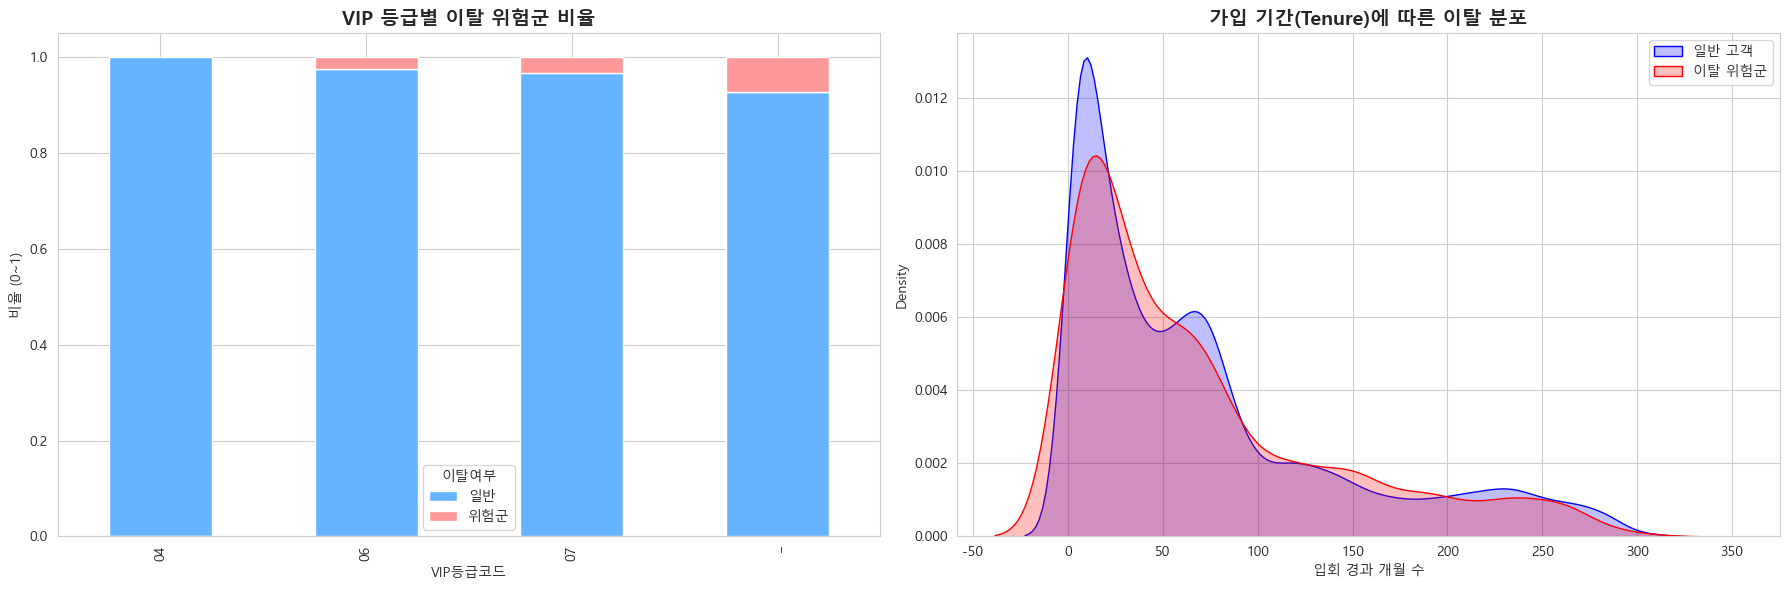

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 설정 (앞서 성공한 방법 2 적용 유지)
# plt.rc('font', family='Malgun Gothic') # 윈도우라면

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# (1) VIP 등급별 이탈 비율 (Stacked Bar Chart)
# 가설: VIP 등급이 낮을수록(일반 등급) 이탈 위험이 높지 않을까?
if 'VIP등급코드' in df.columns:
    ct = pd.crosstab(df['VIP등급코드'], df['Churn_Probabilistic'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axes[0], color=['#66b3ff', '#ff9999'])
    axes[0].set_title('VIP 등급별 이탈 위험군 비율', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('비율 (0~1)')
    axes[0].legend(title='이탈여부', labels=['일반', '위험군'])

# (3) 가입 기간(Tenure) 비교 (KDE Plot)
# 가설: 가입한 지 얼마 안 된 신규 고객이 더 잘 이탈할까? (아니면 오래된 고객?)
if '입회경과개월수_신용' in df.columns:
    sns.kdeplot(data=df[df['Churn_Probabilistic'] == 0]['입회경과개월수_신용'], shade=True, color="blue", label="일반 고객", ax=axes[1])
    sns.kdeplot(data=df[df['Churn_Probabilistic'] == 1]['입회경과개월수_신용'], shade=True, color="red", label="이탈 위험군", ax=axes[1])
    axes[1].set_title('가입 기간(Tenure)에 따른 이탈 분포', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('입회 경과 개월 수')
    axes[1].legend()

plt.tight_layout()
plt.show()

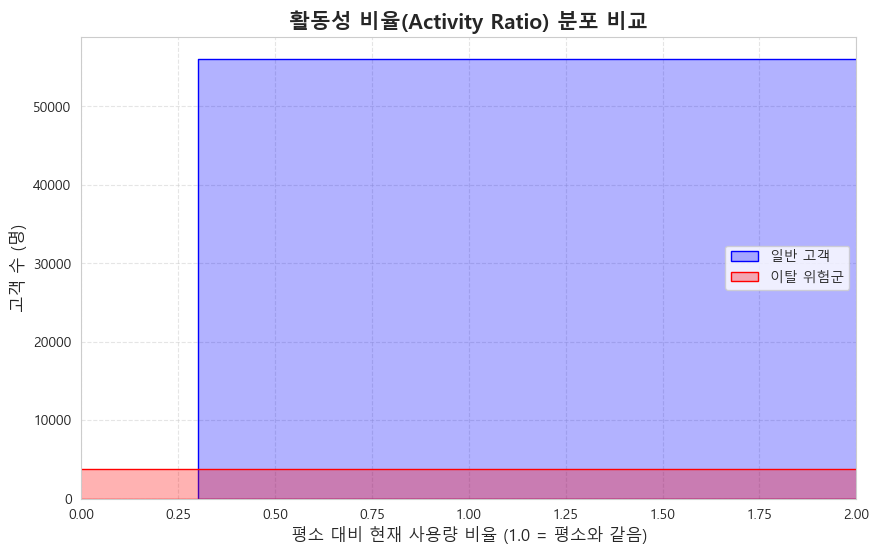

In [22]:
plot_df = df.copy()
if 'Activity_Ratio' not in plot_df.columns:
    # 0으로 나누기 방지를 위한 처리
    plot_df['Avg_Spend_R3M'] = plot_df['이용금액_신용_R3M'] / 3
    plot_df['Activity_Ratio'] = np.where(plot_df['Avg_Spend_R3M'] > 0, 
                                         plot_df['이용금액_신용_B0M'] / plot_df['Avg_Spend_R3M'], 
                                         1.0)

# (2) 무한대(inf) 및 결측치(NaN) 제거 -> 이거 안 하면 에러 남
plot_df['Activity_Ratio'] = plot_df['Activity_Ratio'].replace([np.inf, -np.inf], 1.0)
plot_df['Activity_Ratio'] = plot_df['Activity_Ratio'].fillna(0)

# -------------------------------------------------------
# 3. 그래프 그리기 (히스토그램)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# 일반 고객 (파란색)
sns.histplot(data=plot_df[plot_df['Churn_Probabilistic'] == 0]['Activity_Ratio'], 
             color="blue", label="일반 고객", element="step", fill=True, alpha=0.3, bins=50)

# 이탈 위험군 (빨간색)
sns.histplot(data=plot_df[plot_df['Churn_Probabilistic'] == 1]['Activity_Ratio'], 
             color="red", label="이탈 위험군", element="step", fill=True, alpha=0.3, bins=50)

# 꾸미기
plt.title('활동성 비율(Activity Ratio) 분포 비교', fontsize=15, fontweight='bold')
plt.xlabel('평소 대비 현재 사용량 비율 (1.0 = 평소와 같음)', fontsize=12)
plt.ylabel('고객 수 (명)', fontsize=12)
plt.xlim(0, 2.0) # 0~2배 사이만 확대해서 보기 (너무 큰 이상치 제외)
plt.legend()
plt.grid(True, alpha=0.5, linestyle='--')

plt.show()